In [1]:
import dask.bag as db
import dask.dataframe as dd
from dotenv import load_dotenv
from src.data.storage import get_S3_fs
from src.features.image_paths import (
    get_children,
    compute_img,
    CITIES_PATH,
    ZONES_SUBPATH,
    IMGS_SUBPATH,
    IMG_PATH_PATTERN,
)
from dask import delayed
import numpy as np
import pandas as pd
from torchvision.io import decode_jpeg
import torch
from PIL import Image

if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

load_dotenv()

Device: cuda


True

In [2]:
S3 = get_S3_fs()
zone_paths = [
    zone
    for city in get_children(S3, "", CITIES_PATH)
    for zone in get_children(S3, city, ZONES_SUBPATH)
]
img_paths = [
    delayed(get_children)(S3, zone_path, IMGS_SUBPATH) for zone_path in zone_paths
]
img_data = [
    compute_img(img_paths_zone, IMG_PATH_PATTERN) for img_paths_zone in img_paths
]
ddf = db.from_delayed(img_data).to_dataframe()

In [3]:
ddf.head()

,imgPath,city,zone,store,menuRow,format
0,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,0,.jpeg
1,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,1,.jpeg
2,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,10,.jpeg
3,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,11,.jpeg
4,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,12,.jpeg


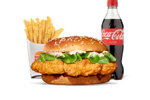

In [4]:
path = ddf[ddf.format == ".jpg"].loc[:, "imgPath"].compute().values[0]
S3 = get_S3_fs()
with S3.open(path, mode="rb") as f:
    a = Image.open(f)
    a.thumbnail(size=(150, 150))
    a.show()

In [5]:
def compute_shape(path: str) -> pd.Series:
    S3 = get_S3_fs()
    with S3.open(path, mode="rb") as f:
        a = Image.open(f)
    return pd.Series({"height": a.height, "width": a.width})

In [6]:
def tensorize(path: str) -> torch.Tensor:
    S3 = get_S3_fs()
    with S3.open(path, mode="rb") as f:
        img_array = np.frombuffer(f.read(), dtype="uint8")
    t = torch.from_numpy(img_array.copy())
    tensor_image = decode_jpeg(
        t,
         device=my_device,
    )
    return tensor_image

In [7]:
ddf_size = ddf.imgPath[ddf.format == ".jpeg"].apply(
    compute_shape, meta={"height": int, "width": int}
)
output_ddf = ddf.assign(height=ddf_size.height, width=ddf_size.width)

In [8]:
output_ddf.head()

,imgPath,city,zone,store,menuRow,format,height,width
0,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,0,.jpeg,2848,4272
1,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,1,.jpeg,2762,4144
2,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,10,.jpeg,800,1200
3,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,11,.jpeg,800,1200
4,food-delivery-crawler/data/images/deliveroo.it...,bergamo,alzano-lombardo,pony-burger,12,.jpeg,800,1200
